In [1]:
import numpy as np
import sys
import gsw
import glob
import xarray as xr
import numpy as np
import time
from scipy import integrate
from scipy.optimize import curve_fit
from copy import deepcopy 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LogNorm
from matplotlib.gridspec import GridSpec
import cmocean
import cmocean as cmo
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib as mpl
from xgcm import Grid 
import datetime as dt
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

sys.path.append('/Users/jakesteinberg/ECCOv4-py/ECCOv4-py')
import ecco_v4_py as ecco

In [2]:
def pharand(u):
    [n,m] = np.shape(u)
    n2 = np.fix(n/2)
    # if 2*n2 == n:
    #     n2 = np.int(n2)
    if 2*n2 < n:     # if odd 
        n2 = n2 + 1
    n2 = np.int(n2)
    U = np.fft.fft(u,axis=0)
    R=np.abs(U[0:n2,:])
    theta=np.random.rand(n2,m)*2*np.pi
    P=np.exp(1j*theta)
    U1top = R*P
    U2bot=np.conj(np.flipud(U1top))
    if 2*n2 == n:  ## EVEN 
        # U1 = np.concatenate((U1top, U[n2+1,:][:,None], U2bot[1:n2,:]),axis=0) # if single column
        U1 = np.concatenate((U1top, U[n2,:][None,:], U2bot[0:n2-1,:]),axis=0)
    else:          ## ODD 
        U1 = np.concatenate((U1top, U2bot[0:n2-1,:]),axis=0)    
    U1[0,:] = U[0,:]
    u1 = np.transpose(np.real(np.fft.ifft(U1,axis=0)))
    return u1

In [3]:
test_path = '/Users/jakesteinberg/Documents/NASA_OSTST/ECCO/v5/nctiles_monthly/PHIBOT/PHIBOT_2017.nc'
test = xr.open_dataset(test_path)
# test2_path = '/Users/jakesteinberg/Documents/NASA_OSTST/ECCO/v5/nctiles_monthly/PHIBOT_0/PHIBOT_2017.nc'
# test2 = xr.open_dataset(test2_path)

In [4]:
# base_dir = '/home/username/'
base_dir = '/Users/jakesteinberg/Documents/NASA_OSTST/ECCO/'
## define a high-level directory for ECCO fields
ECCO_dir = base_dir + '/v5'
## Load the model grid
grid_dir= ECCO_dir + '/nctiles_grid/'
# ecco_grid = ecco.load_ecco_grid_nc(grid_dir, 'ECCOv4r3_grid.nc', k_subset=[0])
ecco_grid = ecco.load_ecco_grid_nc(grid_dir, 'ECCO-GRID.nc')

In [5]:
## Load 2D Monthly data...SSH 
data_dir= ECCO_dir + '/nctiles_monthly'
# ecco_daily_vars = ecco.recursive_load_ecco_var_from_years_nc(data_dir, vars_to_load=['SSHDYN','OBPNOPAB', 'RHOAnoma'], \
#                                                              years_to_load=range(2011,2018)).load() # ,'PHIHYD','RHOAnoma','SALT','UVEL','VVEL'    
ecco_daily_vars = ecco.recursive_load_ecco_var_from_years_nc(data_dir, \
                                           vars_to_load=['ETAN', 'PHIBOT'],\
                                           years_to_load=range(2008,2018)).load()    
## Merge the ecco_grid with the ecco_vars to make the ecco_ds
ecco_monthly_ds = xr.merge((ecco_grid , ecco_daily_vars))

# build grid object 
metrics = {
    ('X',): ['dxC', 'dxG'], # X distances
    ('Y',): ['dyC', 'dyG'], # Y distances
    ('X', 'Y'): ['rA', 'rAz', 'rAs', 'rAw'] # Areas
}
# XC distance from grid center point to center point 
# XG distance from grid egde (where u is defined) to grid edge (finite difference of values at XC will be placed here)
grid = Grid(ecco_monthly_ds, metrics=metrics)

loading files of  ETAN
loading files of  PHIBOT


In [6]:
g = 9.81
rho0=1029
# -- MASK -- at the surface and total ocean area 
ocean_mask = np.ceil(ecco_monthly_ds.hFacC[0])
ocean_mask = ocean_mask.where(ocean_mask==1, np.nan)
total_ocean_area = np.sum(ecco_monthly_ds.rA*ocean_mask)

In [6]:
# constants 
# g = 9.81 
# rho0 = 1029
# ocean_mask = np.ceil(ecco_monthly_ds.hFacC[0])
# ocean_mask = ocean_mask.where(ocean_mask==1, np.nan)
# total_ocean_area = np.sum(ecco_monthly_ds.rA*ocean_mask)

In [7]:
# total ocean area
dep_globe = ecco_monthly_ds.Depth
dep_globe = dep_globe.where(ecco_monthly_ds.hFacC.isel(k=0) !=0, np.nan)
A_globe = ecco_monthly_ds.rA*ocean_mask        # cell area 
As_globe = total_ocean_area
# take layers as cell thicknesses 
imast = ecco_monthly_ds.drF.data.cumsum()[0:45]
# loop over each layer and compute area 
AA_globe = []
for i in range(len(imast)):
    AA_globe.append(np.nansum(A_globe.where(dep_globe <= imast[i], np.nan)))    # area where depth less than or equal to current depth 
# turn into array 
AAi_globe = np.array([AA_globe.copy()])
AAi_globe[0,0] = As_globe                                               # first value is surface area 
AAi_globe[0,1:] = As_globe.data - np.array([AA_globe[0:-1]])            # area in layer i is total area minus area of depths shallower than i 
print('percent of total area for each layer ' + str(np.round(100*(AAi_globe/total_ocean_area.data),1)))

percent of total area for each layer [[100.   99.5  98.7  98.2  97.6  97.   96.4  96.1  95.7  95.4  95.   94.8
   94.6  94.3  94.1  94.1  93.5  93.1  92.8  92.4  92.   91.6  91.2  90.7
   90.3  90.   89.7  89.4  89.1  88.8  88.4  88.   87.6  87.3  86.8  86.2
   85.6  84.8  83.5  82.2  80.4  77.6  73.7  67.6  59.5]]


In [8]:
# extract a single tile 
tile_num=10
lon_range = [-98, -78]; lat_range = [17, 31] 
# -- pull out lats and lons
lons = ecco_monthly_ds.XC.sel(tile=tile_num)
lats = ecco_monthly_ds.YC.sel(tile=tile_num)
lons_g = ecco_monthly_ds.XG.sel(tile=tile_num)
lats_g = ecco_monthly_ds.YG.sel(tile=tile_num)

In [9]:
# bathymetry 
dep = ecco_monthly_ds.Depth
# dep = dep.where(ecco_monthly_ds.hFacC.isel(tile=tile_num,k=0) !=0, np.nan) # NAN out only for tile 10
dep = dep.where(ecco_monthly_ds.hFacC.isel(k=0) !=0, np.nan)

In [10]:
# -- mask at the surface and total ocean area 
# ocean_mask = np.ceil(ecco_monthly_ds.hFacC[0])
# ocean_mask = ocean_mask.where(ocean_mask==1, np.nan)
# total_ocean_area = np.sum(ecco_monthly_ds.rA*ocean_mask)

In [10]:
# LLC270 (load steric height and steric pressure already computed) 
files = glob.glob('/Users/jakesteinberg/Documents/NASA_OSTST/ECCO/' + '/rho_270_steric*.nc')
files = np.sort(files)
# files_t = glob.glob('/Users/jakesteinberg/Documents/NASA_OSTST/ECCO/' + '/rho_270_theta*.nc')
# files_t = np.sort(files_t)
count = 0
for i in range(15,len(files)):
    this_file = xr.open_dataset(files[i]);
    # this_file_t = xr.open_dataset(files_t[i]);
    if count < 1:
        ds_den = this_file.steric_p
        ds_den_r = this_file.rho
        # ds_theta_r = this_file_t.theta
    else:
        ds_den = xr.concat([ds_den, this_file.steric_p], dim="time")
        ds_den_r = xr.concat([ds_den_r, this_file.rho], dim="time")
        # ds_theta_r = xr.concat([ds_theta_r, this_file_t.theta], dim="time")
    print(files[i])
    count = count + 1

/Users/jakesteinberg/Documents/NASA_OSTST/ECCO/rho_270_steric_2008.nc
/Users/jakesteinberg/Documents/NASA_OSTST/ECCO/rho_270_steric_2009.nc
/Users/jakesteinberg/Documents/NASA_OSTST/ECCO/rho_270_steric_2010.nc
/Users/jakesteinberg/Documents/NASA_OSTST/ECCO/rho_270_steric_2011.nc
/Users/jakesteinberg/Documents/NASA_OSTST/ECCO/rho_270_steric_2012.nc
/Users/jakesteinberg/Documents/NASA_OSTST/ECCO/rho_270_steric_2013.nc
/Users/jakesteinberg/Documents/NASA_OSTST/ECCO/rho_270_steric_2014.nc
/Users/jakesteinberg/Documents/NASA_OSTST/ECCO/rho_270_steric_2015.nc
/Users/jakesteinberg/Documents/NASA_OSTST/ECCO/rho_270_steric_2016.nc
/Users/jakesteinberg/Documents/NASA_OSTST/ECCO/rho_270_steric_2017.nc


In [11]:
# --- LLC270: remove time mean / spatial mean  -- 
# --- SLA ---  
SSH_global_mean_mon = (ecco_monthly_ds.ETAN*ecco_monthly_ds.rA).sum(dim=['i','j','tile'])/total_ocean_area # global mean time series 
ssh_mgm = ecco_monthly_ds.ETAN - SSH_global_mean_mon  # subtract global spatial mean time series 
ssh_anom = ssh_mgm - ssh_mgm.mean(dim='time')         # subtract time mean at each point          
pssh = ssh_anom.polyfit(dim='time', deg=1)
ssh_a_trend = xr.polyval(ssh_anom['time'], pssh.polyfit_coefficients)
ssh_a_detrend = ssh_anom - ssh_a_trend
s_press = rho0*g*(ssh_a_detrend)
s_press = s_press.where(ecco_monthly_ds.hFacC.isel(tile=tile_num,k=0) !=0, np.nan)
# --- OBP ---  
# obp_cor = 1029*(ecco_monthly_ds.PHIBOT + g*ecco_monthly_ds.Depth)                             # calculate OBP following ECCO code 
obp_cor = 1029*(ecco_monthly_ds.PHIBOT + g*dep)                                               # calculate OBP following ECCO code 
OBP_global_mean_mon = (obp_cor*ecco_monthly_ds.rA).sum(dim=['i','j','tile'])/total_ocean_area # global mean time series 
# - CHOICE 1 - remove global mean time series and local time mean 
obp_mgm = obp_cor - OBP_global_mean_mon        # subtract global spatial mean time series 
obp_anom = obp_mgm - obp_mgm.mean(dim='time')  # subtract time mean at each point 
# - CHOICE 2 - remove local time mean
# obp_anom = obp_cor - obp_cor.mean(dim='time')    # subtract time mean at each point 
pobp = obp_anom.polyfit(dim='time', deg=1)

obp_a_trend = xr.polyval(obp_anom['time'], pobp.polyfit_coefficients)
obp_a_detrend = obp_anom - obp_a_trend
obp = (obp_a_detrend)
obp = obp.where(ecco_monthly_ds.hFacC.isel(tile=tile_num,k=0) !=0, np.nan)
# --- Steric Height --- 
ster_a = 1*(ds_den-ds_den.mean(dim='time'))
pster = ster_a.polyfit(dim='time', deg=1)
ster_a_trend = xr.polyval(ster_a['time'], pster.polyfit_coefficients)
ster_a_detrend = ster_a - ster_a_trend
ster = ster_a_detrend.where(ecco_monthly_ds.hFacC.isel(tile=tile_num,k=0) !=0, np.nan)
# --- density anomalies (old estimate, not needed) ---
# rho_a = ds_den_r - ds_den_r.mean(dim='time')
# p = rho_a.polyfit(dim='time', deg=1)
# rho_a_trend = xr.polyval(rho_a['time'], p.polyfit_coefficients)
# rho_a_detrend = rho_a - rho_a_trend
# rho = rho_a_detrend.where(ecco_monthly_ds.hFacC.isel(tile=tile_num,k=0) !=0, np.nan)

In [15]:
# for plot only (AVISO)
av_path = '/Users/jakesteinberg/Documents/NASA_OSTST/AVISO/cmems_natl_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.25deg_P1D_2005_2010.nc'
av3 = xr.open_dataset(av_path)
av_path = '/Users/jakesteinberg/Documents/NASA_OSTST/AVISO/cmems_natl_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.25deg_P1D_2011_2016.nc'
av4 = xr.open_dataset(av_path)
av_path = '/Users/jakesteinberg/Documents/NASA_OSTST/AVISO/cmems_natl_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.25deg_P1D_2017_2021.nc'
av5 = xr.open_dataset(av_path)
av_tot = xr.concat([av3,av4,av5], dim='time')
avsla_raw = av_tot.sla
avsla_raw_2 = avsla_raw.sel(time=slice("2008-01-01", "2017-12-31"))
avsla_raw_2_mean = avsla_raw_2.mean(dim='time')
avsla_raw_2_a = avsla_raw_2 - avsla_raw_2_mean

In [32]:
# AVISO
filt_len = 30 # boxcar filter 
for i in range(np.shape(avsla_raw_2_a)[1]):
    for j in range(np.shape(avsla_raw_2_a)[2]):
        avsla_raw_2_a[:,i,j] = np.convolve((1/30)*np.ones(30),avsla_raw_2_a[:,i,j])[np.int(filt_len/2):-np.int(filt_len/2)+1]

In [33]:
# AVISO
pavsla_2 = avsla_raw_2_a.polyfit(dim='time', deg=1) # fitting the anomaly here! 
aviso_2_sla_trend = pavsla_2.polyfit_coefficients.isel(degree=0)*1e9*60*60*24*365*1000

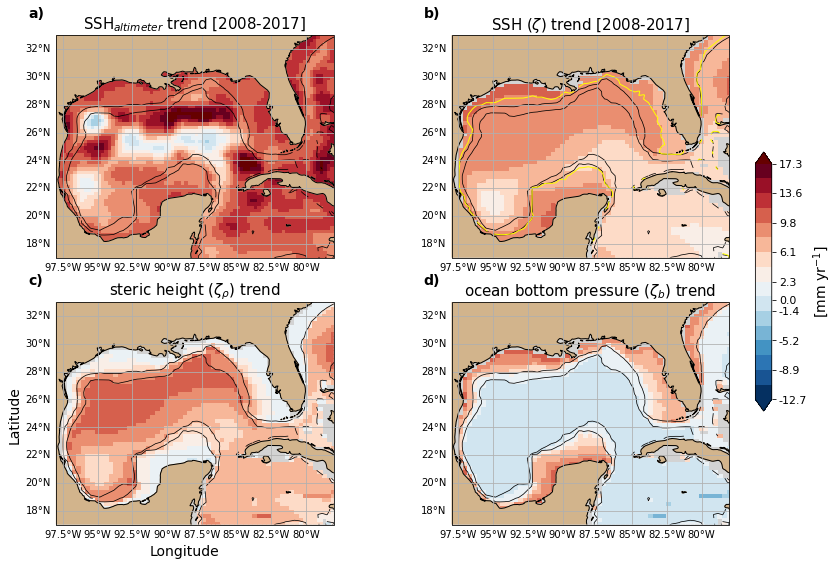

In [173]:
lon_w = -98; lon_e = -78; lat_s = 17; lat_n = 33; 
colMapse = plt.get_cmap('RdBu_r',16); 
colMapse.set_over(color='#660000');
# cmin = 1000*(0.0030186245502099134 - 0.01); cmax = 1000*(0.0030186245502099134 + 0.01)
gom_m_trend_plot = 0.00230802602731798
cmin = 1000*(gom_m_trend_plot - 0.015 - 0.00001); cmax = 1000*(gom_m_trend_plot + 0.015+0.00001);
ocean_mask = np.ceil(ecco_monthly_ds.hFacC[0]); ocean_mask = ocean_mask.where(ocean_mask==1, np.nan)
skill = 1 - ((rho0*g*ssh_anom.isel(tile=tile_num) - obp_anom.isel(tile=tile_num)).var(dim='time')) / \
             ((rho0*g*ssh_anom.isel(tile=tile_num)).var(dim='time'))

f, ax = plt.subplots(2,2,figsize=(13,9), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)})

# --- only altimeter reference
Kc = aviso_2_sla_trend.plot(ax=ax[0,0],transform=ccrs.PlateCarree(),add_colorbar=False,vmin=cmin,vmax=cmax,cmap=colMapse)
ax[0,0].contour(lons, lats, dep.isel(tile=tile_num), [150], linewidths=0.75, colors='k', transform=ccrs.PlateCarree())
ax[0,0].contour(lons, lats, dep.isel(tile=tile_num), [1000], linewidths=0.75, colors='k', transform=ccrs.PlateCarree())
ax[0,0].add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1); ax[0,0].coastlines()
gl = ax[0,0].gridlines(draw_labels=True); gl.xlabels_top = False; gl.ylabels_right = False;
ax[0,0].set_xlim([lon_w, lon_e]); ax[0,0].set_ylim([lat_s, lat_n]);
ax[0,0].set_title(r'SSH$_{altimeter}$ trend [2008-2017]',fontsize=15)
# ---

pes = pssh.polyfit_coefficients.sel(tile=tile_num,degree=1).data*1e9*60*60*24*365*1000
cc = ax[0,1].pcolor(lons, lats, pes*ocean_mask.sel(tile=tile_num), transform=ccrs.PlateCarree(),cmap=colMapse,vmin=cmin,vmax=cmax); 
ax[0,1].contour(lons, lats, dep.isel(tile=tile_num), [150], linewidths=0.75, colors='k', transform=ccrs.PlateCarree())
ax[0,1].contour(lons, lats, dep.isel(tile=tile_num), [1000], linewidths=0.75, colors='k', transform=ccrs.PlateCarree())
ax[0,1].contour(lons, lats, skill, [0.5], linewidths=1, colors='#ffff00', transform=ccrs.PlateCarree())
ax[0,1].add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1); ax[0,1].coastlines()

gl = ax[0,1].gridlines(draw_labels=True); gl.xlabels_top = False; gl.ylabels_right = False; 
# ax.set_xlabel('Longitude',fontsize=14)
# ax.set_ylabel('Latitude',fontsize=14)
# ax.set_xticks([18,20,22,24,26,28,30,32])
# ax.set_yticks([-97.5,-95,-92.5,-90,-87.5,-85,-82.5,-80])
ax[0,1].set_xlim([lon_w, lon_e]); ax[0,1].set_ylim([lat_s, lat_n])
ax[0,1].set_facecolor('#D3D3D3'); ax[0,1].grid(); # ax.set_xticks([-95,-90,-85,-80]) 
ax[0,1].set_title(r'SSH ($\zeta$) trend [2008-2017]',fontsize=15)
ax[0,1].set_xlabel('Longitude',fontsize=14); # ax[0,1].set_ylabel('Latitude',fontsize=14)

peo = pobp.polyfit_coefficients.sel(tile=tile_num,degree=1)*1e9*60*60*24*365/g/rho0*1000
cc = ax[1,1].pcolor(lons, lats, peo*ocean_mask.sel(tile=tile_num), transform=ccrs.PlateCarree(),cmap=colMapse,vmin=cmin,vmax=cmax); 
ax[1,1].contour(lons, lats, dep.isel(tile=tile_num), [150], linewidths=0.75, colors='k', transform=ccrs.PlateCarree())
ax[1,1].contour(lons, lats, dep.isel(tile=tile_num), [1000], linewidths=0.75, colors='k', transform=ccrs.PlateCarree())
ax[1,1].add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1); ax[1,1].coastlines()
gl = ax[1,1].gridlines(draw_labels=True); gl.xlabels_top = False; gl.ylabels_right = False;
ax[1,1].set_xlim([lon_w, lon_e]); ax[1,1].set_ylim([lat_s, lat_n]);  ax[1,1].grid(); 
ax[1,1].set_title(r'ocean bottom pressure ($\zeta_b$) trend',fontsize=15)
ax[1,1].set_facecolor('#D3D3D3'); ax[1,1].set_ylabel('Latitude',fontsize=14)

pes = pster.polyfit_coefficients.sel(degree=1)*1e9*60*60*24*365/g/rho0*1000
cc = ax[1,0].pcolor(lons, lats, pes*ocean_mask.sel(tile=tile_num), transform=ccrs.PlateCarree(),cmap=colMapse,vmin=cmin,vmax=cmax); 
ax[1,0].contour(lons, lats, dep.isel(tile=tile_num), [150], linewidths=0.75, colors='k', transform=ccrs.PlateCarree())
ax[1,0].contour(lons, lats, dep.isel(tile=tile_num), [1000], linewidths=0.75, colors='k', transform=ccrs.PlateCarree())
ax[1,0].add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1); ax[1,0].coastlines()
gl = ax[1,0].gridlines(draw_labels=True); gl.xlabels_top = False; gl.ylabels_right = False;
ax[1,0].set_xlim([lon_w, lon_e]); ax[1,0].set_ylim([lat_s, lat_n]); ax[1,0].set_facecolor('#D3D3D3'); ax[1,0].grid(); 
ax[1,0].set_title(r'steric height ($\zeta_{\rho}$) trend',fontsize=15); 

yt = np.array([np.round(1000*(gom_m_trend_plot-0.015),1), np.round(1000*((gom_m_trend_plot-0.015)+(0.03/8)),1), np.round(1000*((gom_m_trend_plot-0.015)+(2*0.03/8)),1), \
               np.round(1000*((gom_m_trend_plot-0.015)+(3*0.03/8)),1), 0, np.round(1000*((gom_m_trend_plot-0.015)+(4*0.03/8)),1), \
               np.round(1000*((gom_m_trend_plot-0.015)+(5*0.03/8)),1), np.round(1000*((gom_m_trend_plot-0.015)+(6*0.03/8)),1), \
               np.round(1000*((gom_m_trend_plot-0.015)+(7*0.03/8)),1), np.round(1000*(gom_m_trend_plot+0.015),1)])
cbpos = [0.9, 0.3, 0.0175, 0.4]; cax = f.add_axes(cbpos); 
# cb = f.colorbar(cc, cax=cax, orientation='vertical', extend='neither', \
#                 ticks=np.array([1000])*[gom_m_trend_plot-0.015,-0.01,-0.0075,-0.005,-0.0025,0,gom_m_trend_plot,0.005,0.0075,0.01,0.0125,0.015,gom_m_trend_plot+0.015]) # [-0.005,-0.0025,0,gom_m_trend_plot,0.005,0.0075,0.01]
cb = f.colorbar(cc, cax=cax, orientation='vertical', extend='both',ticks=yt)
cb.ax.tick_params(labelsize=11)
cb.ax.set_ylabel('[mm yr$^{-1}$]',fontsize=14)
cb.set_ticklabels(yt)
# cb.set_ticklabels([str(np.round((gom_m_trend_plot-0.015)*1000,1)),'-10','-7.5','-5','-2.5','0',str(np.round(gom_m_trend_plot*1000,1)),'5','7.5','10','12.5','15',str(np.round((gom_m_trend_plot+0.015)*1000,1))])
ax[0,0].text(lon_w-2,lat_n+1.25,'a)',fontsize=14,fontweight='bold'); ax[0,1].text(lon_w-2,lat_n+1.25,'b)',fontsize=14,fontweight='bold'); 
ax[1,0].text(lon_w-2,lat_n+1.25,'c)',fontsize=14,fontweight='bold'); ax[1,1].text(lon_w-2,lat_n+1.25,'d)',fontsize=14,fontweight='bold')
ax[1,0].text(-91.25,14.75,'Longitude',fontsize=14)
ax[1,0].text(-101.5,23,'Latitude',rotation=90,fontsize=14)
f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/manuscript/figures_v2/f3_ecco_ssh_obp_ster_scb.jpg', dpi=300)

In [63]:
yt = [gom_m_trend_plot-0.015, (gom_m_trend_plot-0.015)+(0.03/9), (gom_m_trend_plot-0.015)+(2*0.03/9), (gom_m_trend_plot-0.015)+(3*0.03/9), (gom_m_trend_plot-0.015)+(4*0.03/9), \
      (gom_m_trend_plot-0.015)+(5*0.03/9), (gom_m_trend_plot-0.015)+(6*0.03/9), (gom_m_trend_plot-0.015)+(7*0.03/9), (gom_m_trend_plot-0.015)+(8*0.03/9), gom_m_trend_plot+0.015]

0.01730802602731798

In [109]:
# pes = pster.polyfit_coefficients.sel(degree=1)*1e9*60*60*24*365/g/rho0*1000
np.nanmean(aviso_2_sla_trend*aviso_gulf_mask)

9.510782541347155

In [110]:
# -- AVISO Gulf of Mexico Mask -- 
a_lons, a_lats = np.meshgrid(avsla_raw_2_a.longitude.data, avsla_raw_2_a.latitude.data)
aviso_gulf_mask = xr.DataArray(
    data=np.ones(np.shape(avsla_raw_2_a[0])),
    coords=dict(
        latitude=(["latitude"], avsla_raw_2_a.latitude.data), longitude=(["longitude"], avsla_raw_2_a.longitude.data),
    ),
)
lon_w = -98; lon_e = -80; lat_s = 17; lat_n = 31; 
aviso_gulf_mask = aviso_gulf_mask.where(a_lons > lon_w, np.nan); aviso_gulf_mask = aviso_gulf_mask.where(a_lons < lon_e, np.nan)
aviso_gulf_mask = aviso_gulf_mask.where(a_lats > lat_s, np.nan); aviso_gulf_mask = aviso_gulf_mask.where(a_lats < lat_n, np.nan)
# subdivisions 
sub1 = np.where((a_lons > -81.75) & (a_lats > 25))
aviso_gulf_mask[np.arange(sub1[0][0],sub1[0][-1]), np.arange(sub1[1][0],sub1[1][-1])] = np.nan
aviso_gulf_mask = aviso_gulf_mask.where(a_lons < -81, np.nan)
sub2 = np.where((a_lons > -88) & (a_lats < 21.85))
aviso_gulf_mask[np.arange(sub2[0][0],sub2[0][-1]), np.arange(sub2[1][0],sub2[1][-1])] = np.nan
sub3 = np.where((a_lons > -84) & (a_lats < 23))
aviso_gulf_mask[np.arange(sub3[0][0],sub3[0][-1]), np.arange(sub3[1][0],sub3[1][-1])] = np.nan

In [111]:
# -- N.Atl. Mask -- 
natl_mask = xr.DataArray(
    data=ocean_mask.isel(tile=tile_num), dims=["j", "i"],
    coords=dict(
        i=(["i"], ecco_monthly_ds.XC.i.data), j=(["j"], ecco_monthly_ds.XC.j.data),
        XC=(["j","i"], ecco_monthly_ds.XC.isel(tile=tile_num).data), YC=(["j","i"], ecco_monthly_ds.YC.isel(tile=tile_num).data), 
    ),
)
natl_lon_w = -82; natl_lon_e = -39; natl_lat_s = 14; natl_lat_n = 50; 
natl_mask = natl_mask.where(lons > natl_lon_w, np.nan); natl_mask = natl_mask.where(lons < natl_lon_e, np.nan)
natl_mask = natl_mask.where(lats > natl_lat_s, np.nan); natl_mask = natl_mask.where(lats < natl_lat_n, np.nan)
# -- subdivisions 
# sub1 = np.where((lons > -81.75) & (lats > 25))
# gulf_mask[np.arange(sub1[0][0],sub1[0][-1]), np.arange(sub1[1][0],sub1[1][-1])] = np.nan
# gulf_mask = gulf_mask.where(lons < -81, np.nan)
# sub2 = np.where((lons > -88) & (lats < 21.85))
# gulf_mask[np.arange(sub2[0][0],sub2[0][-1]), np.arange(sub2[1][0],sub2[1][-1])] = np.nan
# sub3 = np.where((lons > -84) & (lats < 23))
# gulf_mask[np.arange(sub3[0][0],sub3[0][-1]), np.arange(sub3[1][0],sub3[1][-1])] = np.nan

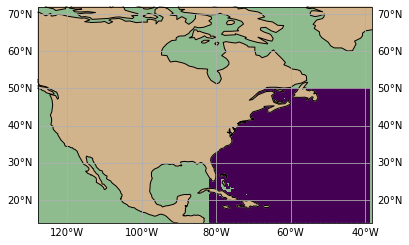

In [112]:
# -- plot mask -- 
f, ax = plt.subplots(1,1,figsize=(6,4), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)})
ax.pcolor(lons, lats, natl_mask, transform=ccrs.PlateCarree()); ax.grid(); 
ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1); ax.coastlines()
gl = ax.gridlines(draw_labels=True); gl.xlabels_top = False;
ax.set_facecolor('#8FBC8F'); 
# ax.set_xlim([lon_w, lon_e]); ax.set_ylim([lat_s, lat_n])

In [312]:
natl_pes = pster.polyfit_coefficients.sel(degree=1)*1e9*60*60*24*365/g/rho0*1000
np.nanmean(natl_pes*natl_mask)

7.7188694850453805

Text(0.5, 1.0, 'Skill: Steric Height, SLA Correspondence')

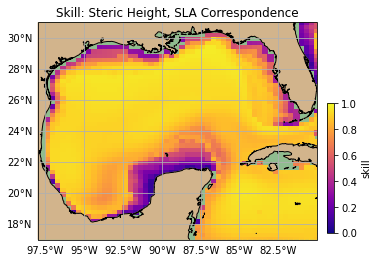

In [14]:
# show correspondence between SLA, OBP, and steri height as a function of depth 
lon_w = -98; lon_e = -80; lat_s = 17; lat_n = 31; 
skill = 1 - ((s_press.isel(tile=tile_num) - (ster)).var(dim='time')) / \
             ((s_press.isel(tile=tile_num)).var(dim='time'))
colMap = plt.get_cmap('plasma');
f, ax = plt.subplots(1,1,figsize=(6,4), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)})
cc =ax.pcolor(lons, lats, skill, transform=ccrs.PlateCarree(),cmap=colMap,vmin=0,vmax=1); ax.grid(); 
ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1); ax.coastlines()
gl = ax.gridlines(draw_labels=True); gl.xlabels_top = False; gl.ylabels_right = False;
ax.set_facecolor('#8FBC8F'); ax.set_xlim([lon_w, lon_e]); ax.set_ylim([lat_s, lat_n])
cbpos = [0.86, 0.15, 0.015, 0.45]; cax = f.add_axes(cbpos); 
cb = f.colorbar(cc, cax=cax, orientation='vertical', extend='neither', label='skill')
ax.set_title('Skill: Steric Height, SLA Correspondence')
# f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/meetings/2022_04_20/GOM_ecco_sla_ster_skill.jpg', dpi=250)

In [113]:
# -- Gulf of Mexico Mask -- 
gulf_mask = xr.DataArray(
    data=ocean_mask.isel(tile=tile_num), dims=["j", "i"],
    coords=dict(
        i=(["i"], ecco_monthly_ds.XC.i.data), j=(["j"], ecco_monthly_ds.XC.j.data),
        XC=(["j","i"], ecco_monthly_ds.XC.isel(tile=tile_num).data), YC=(["j","i"], ecco_monthly_ds.YC.isel(tile=tile_num).data), 
    ),
)
lon_w = -98; lon_e = -80; lat_s = 17; lat_n = 31; 
gulf_mask = gulf_mask.where(lons > lon_w, np.nan); gulf_mask = gulf_mask.where(lons < lon_e, np.nan)
gulf_mask = gulf_mask.where(lats > lat_s, np.nan); gulf_mask = gulf_mask.where(lats < lat_n, np.nan)
# subdivisions 
sub1 = np.where((lons > -81.75) & (lats > 25))
gulf_mask[np.arange(sub1[0][0],sub1[0][-1]), np.arange(sub1[1][0],sub1[1][-1])] = np.nan
gulf_mask = gulf_mask.where(lons < -81, np.nan)
sub2 = np.where((lons > -88) & (lats < 21.85))
gulf_mask[np.arange(sub2[0][0],sub2[0][-1]), np.arange(sub2[1][0],sub2[1][-1])] = np.nan
sub3 = np.where((lons > -84) & (lats < 23))
gulf_mask[np.arange(sub3[0][0],sub3[0][-1]), np.arange(sub3[1][0],sub3[1][-1])] = np.nan

Text(0.5, 1.0, 'shifted grid')

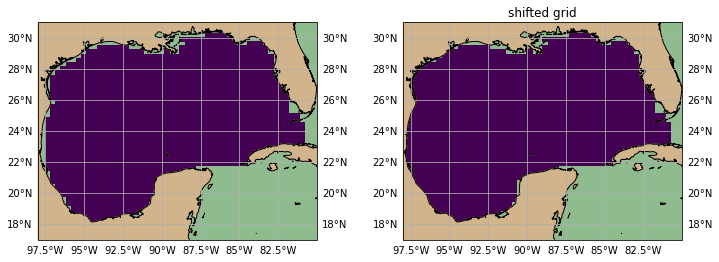

In [114]:
# PLOT mask 
f, (ax,ax2) = plt.subplots(1,2,figsize=(12,4), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)})
ax.pcolor(lons, lats, gulf_mask, transform=ccrs.PlateCarree()); ax.grid(); 
ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1); ax.coastlines()
gl = ax.gridlines(draw_labels=True); gl.xlabels_top = False;
ax.set_facecolor('#8FBC8F'); ax.set_xlim([lon_w, lon_e]); ax.set_ylim([lat_s, lat_n])

ax2.pcolor(np.nanmean(gulf_mask.XC,axis=1), np.nanmean(gulf_mask.YC,axis=0), np.transpose(gulf_mask.data), transform=ccrs.PlateCarree()); ax.grid(); 
ax2.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1); ax2.coastlines()
gl = ax2.gridlines(draw_labels=True); gl.xlabels_top = False;
ax2.set_facecolor('#8FBC8F'); ax2.set_xlim([lon_w, lon_e]); ax2.set_ylim([lat_s, lat_n]); ax2.set_title('shifted grid')

In [115]:
da_gulf_mask = xr.DataArray(data=np.transpose(gulf_mask.data), dims=["lat","lon"],
                        coords=dict(
                            lon=(["lon"], np.nanmean(gulf_mask.XC,axis=1)),lat=(["lat"], np.nanmean(gulf_mask.YC,axis=0)),
                        ),
                       )

In [68]:
# -- save mask -- 
# gulf_mask.to_netcdf(path='/Users/jakesteinberg/Documents/NASA_OSTST/ecco_gulf_mask_4.nc')

-6.672288501297696e-19


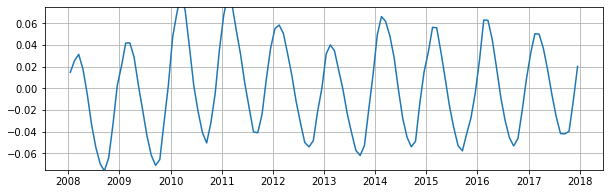

In [256]:
# GOM mean steric time series
gom_mean_steric = -1*(ster*gulf_mask).mean(dim=['i','j'])/g/rho0
f, ax = plt.subplots(1,1,figsize=(10,3))
ax.plot(ster.time,gom_mean_steric)
ax.set_ylim([-0.075,0.075]); ax.grid()
gom_ms_t = gom_mean_steric.polyfit(dim='time', deg=1)
gom_ms_t_coef = gom_ms_t.polyfit_coefficients.isel(degree=0)*1e9*60*60*24*365 # m/yr
print(gom_ms_t_coef.data)

In [116]:
# GOM mean OBP trend (error)
# apply mask to subset time series, fit trend to GOM mean time series 
obp_time_series_wmask = gulf_mask.data*obp_anom.isel(tile=10)
obp_mean_time_series = obp_time_series_wmask.mean(dim=['j','i'])
obp_mean_trend = obp_mean_time_series.polyfit(dim='time', deg=1)
obp_mean_trend = obp_mean_trend.polyfit_coefficients.isel(degree=0)*1e9*60*60*24*365/g/rho0
print(obp_mean_trend.data)

0.002332640270411726


In [318]:
# phase randomization (GOM mean trend error)
data_in = obp_mean_time_series.data[:,None]
n_s = 1000
scram_trend = np.nan*np.ones((n_s,np.shape(data_in)[1]))
for i in range(0,n_s):
    scram = pharand(data_in)
    u1_da = xr.DataArray(data=scram, dims=["location","time"],
                        coords=dict(
                            location=(["location"], np.arange(0,np.shape(scram)[0])), time=(["time"], obp_mean_time_series.time.data)))
    slope = u1_da.polyfit(dim='time', deg=1)
    scram_trend[i,:] = (slope.isel(degree=0).polyfit_coefficients.data)*1e9*60*60*24*365/g/rho0
print(np.nanstd(scram_trend))

0.001272314038632821


In [20]:
# linear trend in theta after applying gulf mask
# -- temperature -- 
theta = ds_theta_r*gulf_mask
theta_a = theta - theta.mean(dim='time')
ptheta = theta_a.polyfit(dim='time', deg=1)

In [49]:
gom_theta_a = theta_a.mean(dim=['i','j'])

In [205]:
# -- temperature trends 
# f, (ax1,ax2,ax3,ax4) = plt.subplots(4,1,figsize=(10,9))
# ax1.plot(theta_a.time,gom_theta_a.isel(layer=6))
# ax1.set_title(str(ecco_grid.Z[6].data) + ' m'); ax1.set_xticklabels(['']); ax1.grid()
# ax2.plot(theta_a.time,gom_theta_a.isel(layer=12))
# ax2.set_title(str(ecco_grid.Z[12].data) + ' m'); ax2.set_xticklabels(['']); ax2.grid()
# ax3.plot(theta_a.time,gom_theta_a.isel(layer=20))
# ax3.set_title(str(ecco_grid.Z[20].data) + ' m'); ax3.set_xticklabels(['']); ax3.grid()
# ax4.plot(theta_a.time,gom_theta_a.isel(layer=25))
# ax4.set_title(str(ecco_grid.Z[25].data) + ' m'); ax4.set_ylabel('temp. anom. [deg]'); ax4.grid()
# f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/meetings/2022_06_23/GOM_ecco_theta_anom.jpg', dpi=250)

In [206]:
# temperature trend anom profile
# imast = ecco_monthly_ds.drF.data.cumsum()
# f, ax = plt.subplots(1,1,figsize=(4,6))
# ax.plot(ptheta.polyfit_coefficients.isel(degree=0).mean(dim=['i','j'])*1e9*60*60*24*365,-1*ecco_grid.Z)
# ax.scatter(ptheta.polyfit_coefficients.isel(degree=0).mean(dim=['i','j'])*1e9*60*60*24*365,-1*ecco_grid.Z,s=5)
# ax.set_ylim([0,3000]); ax.invert_yaxis(); ax.grid(); ax.set_title('temp. anom. trend')
# f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/meetings/2022_06_23/GOM_ecco_theta_anom_trend.jpg', dpi=250)

In [118]:
# -- extract linear OBP trend (from OBP anomaly (subtracted global mean time series and local time mean)
# -- remove GOM mean trend (import of mass into basin)
fitloc = pobp.polyfit_coefficients.isel(degree=0).isel(tile=tile_num)*1e9*60*60*24*365/g/rho0
gulf_area = np.nansum(gulf_mask.data*ecco_monthly_ds.rA.isel(tile=tile_num))
mean_gulf_trend = np.nansum(fitloc*gulf_mask.data*ecco_monthly_ds.rA.isel(tile=tile_num))/gulf_area 
gulf_t_obp = fitloc*gulf_mask
gulf_a_obp = gulf_t_obp - mean_gulf_trend
print(mean_gulf_trend)

0.00230802602731798


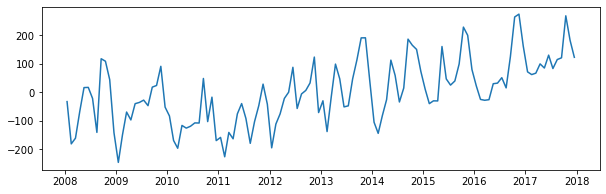

In [133]:
# mean gulf time series 
mean_gulf_timeseries = (obp_anom.isel(tile=tile_num)*gulf_mask).mean(dim=['j','i'])
f, ax = plt.subplots(1,1,figsize=(10,3))
ax.plot(obp_anom.time,mean_gulf_timeseries)
# ax.plot(obp_anom.time,OBP_global_mean_mon)

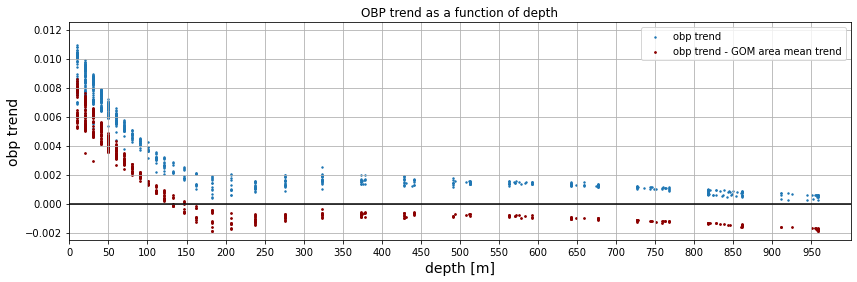

In [119]:
f, ax = plt.subplots(1,1,figsize=(14,4))
ax.plot([0,1500],[0, 0], color='k', linewidth=1.5)
lon_sub = np.where((lons > lon_range[0]) & (lons < lon_range[-1]))[0]; lat_sub = np.where((lats > lat_range[0]) & (lats < lat_range[-1]))[1]
ax.scatter(dep.isel(tile=tile_num).data[lon_sub[0]:lon_sub[-1],:][:,lat_sub[0]:lat_sub[-1]], \
           fitloc.data[lon_sub[0]:lon_sub[-1],:][:,lat_sub[0]:lat_sub[-1]], s=2, label='obp trend'); 
ax.scatter(dep.isel(tile=tile_num)*gulf_mask, gulf_a_obp, s=3, color='#8B0000', label='obp trend - GOM area mean trend'); 
ax.set_xlim([0,1000]); ax.set_ylim([-0.0025,0.0125]);
ax.set_xticks(np.arange(0,1000,50));
# ax.set_xticklabels(['0','25','50','75','100','125','150','175'])
ax.grid(); ax.set_xlabel('depth [m]', fontsize=14); ax.set_ylabel('obp trend', fontsize=14);
ax.set_title('OBP trend as a function of depth');
ax.legend()
# f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/meetings/2022_02_24/GOM_obp_vs_dep.jpg', dpi=250)

Text(0.5, 1.0, 'OBP trend - GOM mean (0.0023 m/year)')

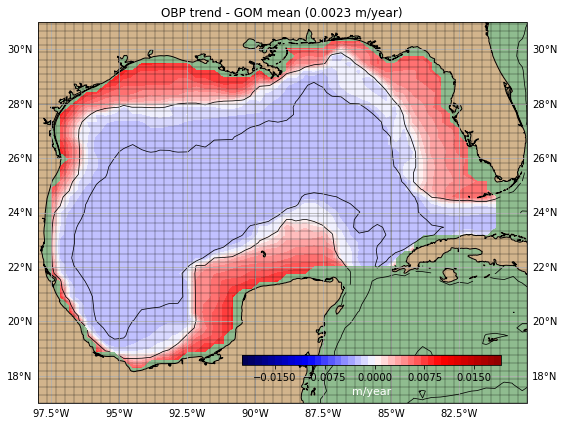

In [211]:
f, ax = plt.subplots(1,1,figsize=(9,7), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)}); clim = [-0.02, 0.02];
colMap = plt.get_cmap('seismic'); colMap.set_over(color='r');
Kc = ax.contourf(lons,lats,gulf_a_obp, levels=np.arange(clim[0], clim[-1],0.001), \
            vmin=clim[0],vmax=clim[-1], cmap=colMap, transform=ccrs.PlateCarree()); 
ax.plot(ecco_monthly_ds.XG.isel(tile=tile_num), ecco_monthly_ds.YG.isel(tile=tile_num),'k-', linewidth=0.3, transform=ccrs.PlateCarree())
ax.plot(ecco_monthly_ds.XG.isel(tile=tile_num).T, ecco_monthly_ds.YG.isel(tile=tile_num).T,'k-', linewidth=0.3, transform=ccrs.PlateCarree())
ax.contour(lons, lats, dep.isel(tile=tile_num), [150], linewidths=0.75, colors='k', transform=ccrs.PlateCarree())
ax.contour(lons, lats, dep.isel(tile=tile_num), [2000], linewidths=0.75, colors='k', transform=ccrs.PlateCarree())
# ax.set_facecolor('#8FBC8F'); ax.set_xlim([lon_w,-81]); ax.set_ylim([18,lat_n]);
ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1); ax.coastlines()
gl = ax.gridlines(draw_labels=True); gl.xlabels_top = False;
ax.set_facecolor('#8FBC8F'); ax.set_xlim([lon_w, lon_e]); ax.set_ylim([lat_s, lat_n])
cbpos = [0.45, 0.2, 0.4, 0.02]; cax = f.add_axes(cbpos); 
cb = f.colorbar(Kc, cax=cax, orientation='horizontal', label='m/year',ticks=[-0.015, -0.0075, 0, 0.0075, 0.015])
cb.set_label(label='m/year', color='w', fontsize=11)
ax.set_title('OBP trend - GOM mean (' + str(np.round(mean_gulf_trend,4)) + ' m/year)')
# f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/meetings/2022_04_08/GOM_obp_trend_anom.jpg', dpi=250)

Text(0.5, 1.0, 'area of layer w/ bottom dep = 1255.54 = A$_s$ minus shaded region')

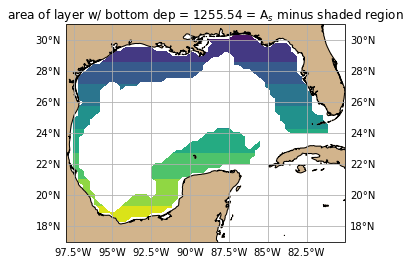

In [122]:
# check on area calculation below 
testi = 30; test = A.where(h <= imast[testi], np.nan); 
f, ax = plt.subplots(1,1,subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)})
ax.contourf(lons,lats,test)
ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1); ax.coastlines()
gl = ax.gridlines(draw_labels=True); gl.xlabels_top = False;
ax.set_facecolor('w'); ax.set_xlim([lon_w, lon_e]); ax.set_ylim([lat_s, lat_n])
ax.set_title(r'area of layer w/ bottom dep = ' + str(imast[testi]) + ' = A$_s$ minus shaded region')
# f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/meetings/2022_04_08/GOM_layer_i_area.jpg', dpi=250)

In [121]:
# surface and layer areas 
h = dep.isel(tile=tile_num)                                 # depth 
A = ecco_monthly_ds.rA.isel(tile=tile_num)*gulf_mask        # cell area 
As = gulf_area 
# take layers as cell thicknesses 
imast = ecco_monthly_ds.drF.data.cumsum()[0:45]
# loop over each layer and compute area 
AA = []
for i in range(len(imast)):
    AA.append(np.nansum(A.where(h <= imast[i], np.nan)))    # area where depth less than or equal to current depth 
# turn into array 
AAi = np.array([AA.copy()])
AAi[0,0] = As                                               # first value is surface area 
AAi[0,1:] = As - np.array([AA[0:-1]])                       # area in layer i is total area minus area of depths shallower than i 
ii = imast
pbdeps = imast                                              # depths at bottom of each cell 

AAi = xr.DataArray(data=AAi[0,:], dims=["layer"],
    coords=dict(layer=(["layer"], np.arange(0,len(pbdeps))),),
)
# percent of total area decreases as layer index increases (as we go deeper )
print('percent of total area for each layer ' + str(np.round(100*(AAi.data/gulf_area),1)))

percent of total area for each layer [100.   96.4  91.3  86.6  82.5  78.7  75.7  74.2  72.9  72.   71.4  70.4
  69.5  69.   68.3  68.3  67.   66.4  65.2  64.4  63.6  62.7  61.8  61.2
  60.3  59.3  58.   56.6  55.5  53.9  52.2  50.5  49.1  47.9  46.4  44.3
  42.4  40.6  37.2  34.8  32.2  28.3  23.8  12.7   0.1]


In [123]:
GOM_mask_plot = gulf_mask.data.copy()
GOM_mask_plot[np.isnan(GOM_mask_plot)] = 0

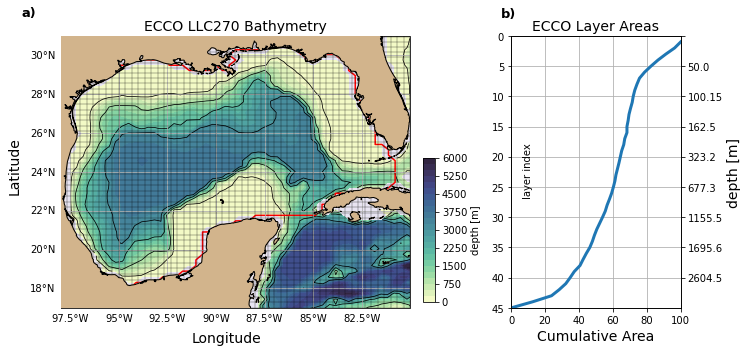

In [167]:
# f, ax = plt.subplots(1,1,figsize=(5,7))
# f, ax = plt.subplots(1,1,figsize=(9,7), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)}); clim = [-0.02, 0.02];
fig = plt.figure(tight_layout=True,figsize=(11,5))
gs = gridspec.GridSpec(1, 4)
ax = fig.add_subplot(gs[0, 0:3], projection = ccrs.PlateCarree(central_longitude=0))
ax2 = fig.add_subplot(gs[0, 3])

colMap = cmo.cm.deep;  
colMap.set_over(color=colMap(1));
Kc = ax.contourf(lons,lats,dep.isel(tile=tile_num), levels=np.arange(0,6250,250), vmin=0, vmax=6250, cmap=colMap, transform=ccrs.PlateCarree()); # levels=np.arange(0,4750,250),
ax.plot(ecco_monthly_ds.XG.isel(tile=tile_num), ecco_monthly_ds.YG.isel(tile=tile_num),'k-', linewidth=0.3, transform=ccrs.PlateCarree())
ax.plot(ecco_monthly_ds.XG.isel(tile=tile_num).T, ecco_monthly_ds.YG.isel(tile=tile_num).T,'k-', linewidth=0.3, transform=ccrs.PlateCarree())
ax.contour(lons, lats, dep.isel(tile=tile_num), [150], linewidths=0.75, colors='k', transform=ccrs.PlateCarree())
ax.contour(lons, lats, dep.isel(tile=tile_num), [1000], linewidths=0.75, colors='k', transform=ccrs.PlateCarree())
ax.contour(lons, lats, dep.isel(tile=tile_num), [2000], linewidths=0.75, colors='k', transform=ccrs.PlateCarree())
ax.contour(lons, lats, dep.isel(tile=tile_num), [3000], linewidths=0.75, colors='k', transform=ccrs.PlateCarree())
ax.contour(np.nanmean(gulf_mask.XC,axis=1), np.nanmean(gulf_mask.YC,axis=0), \
           np.transpose(GOM_mask_plot), [1], transform=ccrs.PlateCarree(), zorder=2, colors='r', linewidth=3);
ax.add_feature(cartopy.feature.LAND, color='#D2B48C', zorder=3); ax.coastlines(zorder=3)
gl = ax.gridlines(draw_labels=True); gl.xlabels_top = False; gl.ylabels_right = False; 
ax.set_facecolor('#e8e4f2'); # ax.set_facecolor('#8EF7F7'); 
ax.set_xlim([lon_w, lon_e]); ax.set_ylim([lat_s, lat_n])
cbpos = [0.585, 0.15, 0.015, 0.4]; cax = fig.add_axes(cbpos); 
cb = f.colorbar(Kc, cax=cax, orientation='vertical', label='depth [m]')
ax.set_title('ECCO LLC270 Bathymetry', fontsize=14)

ax2.plot(np.round(100*(AAi.data/gulf_area),1),np.arange(1,len(AAi)+1),linewidth=3,label='GOM')
# ax2.plot(np.round(100*(AAi_globe/total_ocean_area.data),1)[0,:],np.arange(1,len(AAi)+1),color='k',label='globe')
ax2.grid(); # ax2.legend()
ax2.text(7,26.5,'layer index',fontsize=10,rotation=90); 
ax2.set_xlabel('Cumulative Area',fontsize=14);
ax2.set_ylim([0,45]); ax2.invert_yaxis(); 
ax3 = ax2.twinx()
# ax2.plot(np.round(100*(AAi.data/gulf_area),1),imast)
ax3.set_yticks(np.arange(0,1,1/9))
ax3.set_yticklabels(['',str(imast[4]),str(imast[9]),str(np.round(imast[14],1)),str(np.round(imast[19],1)),\
                     str(np.round(imast[24],1)),\
                    str(np.round(imast[29],1)),str(np.round(imast[34],1)),str(np.round(imast[39],1))])
ax3.invert_yaxis(); ax3.set_ylabel('depth [m]',fontsize=14)
ax2.set_title('ECCO Layer Areas',fontsize=14); ax2.set_xlim([0,100])
ax.text(lon_w-2,lat_n+1,'a)',fontsize=13,fontweight='bold')
ax2.text(-6,-3,'b)',fontsize=13,fontweight='bold'); ax.grid()
ax.text(-91.25,15.25,'Longitude',fontsize=14)
ax.text(-100.75,23,'Latitude',rotation=90,fontsize=14)
fig.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/manuscript/figures_v2/f2_ecco_bathy.jpg', dpi=250)

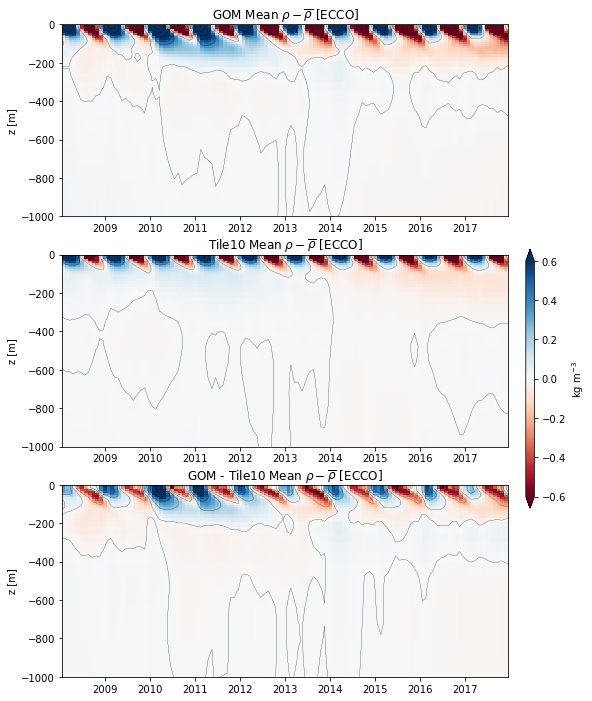

In [124]:
rho_ECCO_0 = ds_den_r*gulf_mask 
rho_ECCO_1 = rho_ECCO_0.mean(dim=['j','i']) # ds_den_r.mean(dim=['j','i'])

# N Atl. Mean rho prime time series 
rho_ECCO_globe_1 = ds_den_r.mean(dim=['j','i'])
f, (ax0,ax1,ax2) = plt.subplots(3,1,figsize=(8,12))

pp = ax0.pcolor(rho_ECCO_1.time,ecco_grid.Z,(rho_ECCO_1 - rho_ECCO_1.mean(dim='time')).transpose(), cmap='RdBu', vmin=-0.6, vmax=0.6)
ax0.contour(rho_ECCO_1.time,ecco_grid.Z,(rho_ECCO_1 - rho_ECCO_1.mean(dim='time')).transpose(), level=[0], colors='k',linewidths=0.25)
ax0.set_title(r'GOM Mean $\rho - \overline{\rho}$ [ECCO]')
ax0.set_ylabel('z [m]'); ax.set_xlabel('year'); # ax.set_xlim([t_s, t_e])
ax0.set_ylim([-1000,0])

pp = ax1.pcolor(rho_ECCO_globe_1.time, ecco_grid.Z, \
               (rho_ECCO_globe_1 - rho_ECCO_globe_1.mean(dim='time')).transpose(), \
               cmap='RdBu', vmin=-0.6, vmax=0.6)
ax1.contour(rho_ECCO_1.time,ecco_grid.Z,(rho_ECCO_globe_1 - rho_ECCO_globe_1.mean(dim='time')).transpose(), level=[0], colors='k',linewidths=0.25)
ax1.set_title(r'Tile10 Mean $\rho - \overline{\rho}$ [ECCO]')
ax1.set_ylabel('z [m]'); ax.set_xlabel('year'); # ax.set_xlim([t_s, t_e])
ax1.set_ylim([-1000,0])
pp = ax2.pcolor(rho_ECCO_globe_1.time, ecco_grid.Z, \
               (rho_ECCO_1 - rho_ECCO_1.mean(dim='time')).transpose() - \
               (rho_ECCO_globe_1 - rho_ECCO_globe_1.mean(dim='time')).transpose(), \
               cmap='RdBu', vmin=-0.6, vmax=0.6)
ax2.contour(rho_ECCO_globe_1.time, ecco_grid.Z,\
               (rho_ECCO_1 - rho_ECCO_1.mean(dim='time')).transpose() - \
               (rho_ECCO_globe_1 - rho_ECCO_globe_1.mean(dim='time')).transpose(), level=[0], colors='k',linewidths=0.25)
ax2.set_title(r'GOM - Tile10 Mean $\rho - \overline{\rho}$ [ECCO]')
ax2.set_ylabel('z [m]'); ax.set_xlabel('year'); # ax.set_xlim([t_s, t_e])
ax2.set_ylim([-1000,0])
cbpos = [0.93, 0.32, 0.015, 0.3]; cax = f.add_axes(cbpos); 
cb = f.colorbar(pp, cax=cax, orientation='vertical', extend='both', label=r'kg m$^{-3}$')
# f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/meetings/2022_08_18/GOM_NAtl_rho.jpg', dpi=250)

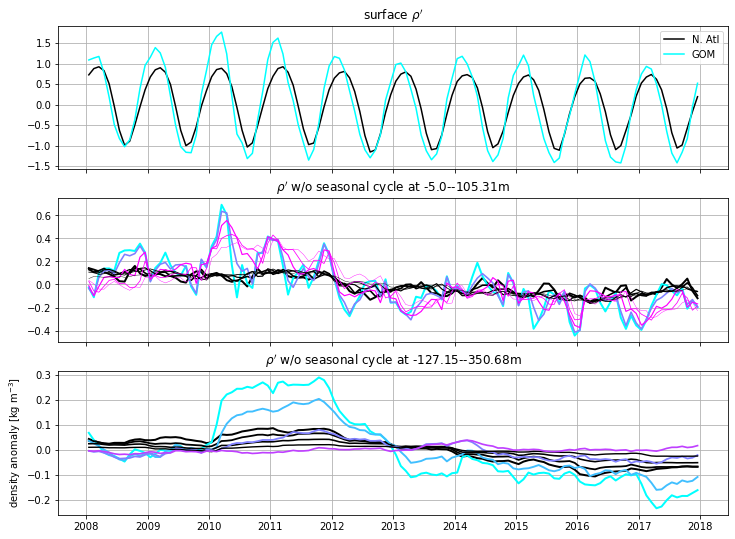

In [66]:
natl_rho_pr = rho_ECCO_globe_1 - rho_ECCO_globe_1.mean(dim='time')
gom_rho_pr = rho_ECCO_1 - rho_ECCO_1.mean(dim='time')

time_ord = np.nan*np.ones(len(rho_ECCO_globe_1.time))
for i in range(len(rho_ECCO_globe_1.time)):
    ts = (np.datetime64(str(rho_ECCO_globe_1.time[i].data)[0:10]) - np.datetime64('0000-01-01T00:00:00Z')) / np.timedelta64(1, 's')
    time_ord[i] = ts/(60*60*24)

def seasonal_cycle(x,a,b,c,d,f):
    return a*np.sin((2*np.pi/365)*x+b) + c*np.sin((2*np.pi/(365/2))*x+d) + f 

zs=22
natl_model = np.nan*np.ones((len(rho_ECCO_globe_1.time),zs))
gom_model = natl_model.copy()
count = 0
for i in range(zs):
    natl_fit = curve_fit(seasonal_cycle, time_ord - time_ord[0], natl_rho_pr[:,i])
    natl_model[:,i] = seasonal_cycle((time_ord - time_ord[0]),*natl_fit[0])
    gom_fit = curve_fit(seasonal_cycle, time_ord - time_ord[0], gom_rho_pr[:,i])
    gom_model[:,i] = seasonal_cycle((time_ord - time_ord[0]),*gom_fit[0])

f, (ax,ax2,ax3) = plt.subplots(3,1,figsize=(12,9))
ax.plot(rho_ECCO_globe_1.time, natl_rho_pr[:,0],color='k',label='N. Atl')
ax.plot(rho_ECCO_globe_1.time, gom_rho_pr[:,0],color=cmap(0),label='GOM')
ax.legend(); ax.grid(); ax.set_xticklabels('')
ax.set_title(r"surface $\rho'$")
cmap = plt.get_cmap('cool',5); count = 0
for i in range(0,12,2):
    ax2.plot(rho_ECCO_globe_1.time,natl_rho_pr[:,i]-natl_model[:,i],color='k',linewidth=2-i*0.2)
    ax2.plot(rho_ECCO_globe_1.time,gom_rho_pr[:,i]-gom_model[:,i],color=cmap(i),linewidth=2-i*0.2)
    count = count+1
ax2.grid(); ax2.set_xticklabels('')
ax2.set_title(r"$\rho'$ w/o seasonal cycle at " + str(ecco_grid.Z[0].data) + '-' + str(ecco_grid.Z[10].data) + 'm')
count = 0
for i in range(12,20,2):
    ax3.plot(rho_ECCO_globe_1.time,natl_rho_pr[:,i]-natl_model[:,i],color='k',linewidth=2-count*0.2)
    ax3.plot(rho_ECCO_globe_1.time,gom_rho_pr[:,i]-gom_model[:,i],color=cmap(count),linewidth=2-count*0.1)
    count = count+1
ax3.set_title(r"$\rho'$ w/o seasonal cycle at " + str(ecco_grid.Z[12].data) + '-' + str(ecco_grid.Z[20].data) + 'm')
ax3.set_ylabel('density anomaly [kg m$^{-3}$]')
ax3.grid()
# f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/meetings/2022_08_18/GOM_NAtl_rho_no_seas.jpg', dpi=250)

In [ ]:
# -- Landerer model choices (what to use for rho') -- 
# -- CAN SKIP AND JUST USE RHO 
# -- density anomaly defined relative to local time mean 
rho_a = ds_den_r - ds_den_r.mean(dim='time')
p = rho_a.polyfit(dim='time', deg=1)
rho_a_trend = xr.polyval(rho_a['time'], p.polyfit_coefficients)
# -- density anomaly defined relative to rho0 
rho_a_rho0 = ds_den_r - rho0
p_rho0 = rho_a_rho0.polyfit(dim='time', deg=1)
rho_a_rho0_trend = xr.polyval(rho_a_rho0['time'], p_rho0.polyfit_coefficients)

In [125]:
# -- Run Landerer Model --
time0 = time.time()
v_cell_t = ecco_grid.hFacC.isel(tile=tile_num)*ecco_grid.drF            # actual layer thicknesses 
v_cell_t = v_cell_t.rename({'k': 'layer'})
v_cell_t = v_cell_t*gulf_mask
# v_cell_z = np.cumsum(ecco_grid.drF.data)[0:45]                          # cumulative sum --> layer depths 
v_cell_z = ecco_grid.Z[0:45]                                                  # depth of vertical cell center 

delta_pb_total = np.nan*np.ones((np.shape(ds_den_r)[0],len(pbdeps)))
lay1 = np.nan*np.ones((np.shape(ds_den_r)[0]))
layb = np.nan*np.ones((np.shape(ds_den_r)[0],len(v_cell_z)-1))
# -- main loop -- 
for tt in range(np.shape(ds_den_r)[0]):                                 # loop over all times 
    for m in range(0,45):                                               # loop over all layers 
        this_i = np.where(-1*v_cell_z <= -1*v_cell_z[m])[0]                   # all depths shallower than depth i 
        this_i = this_i[-1]                                             # deepest index (the layer we care about in this loop)
    
        below_i = np.arange(this_i+1,len(v_cell_z))
        above_i = np.arange(0,this_i+1)
    
        # -- for each layer, multiply rho_prime by layer thickness, then average across basin 
        below = (1/rho0)*( (AAi.isel(layer=below_i)/As)*\
                           (v_cell_t.isel(layer=below_i)*\
                           -1*ds_den_r[tt].isel(layer=below_i)).mean(dim=['j','i'])).sum(dim='layer')
        above = (1/rho0)*((As/AAi.isel(layer=above_i) - 1)*(AAi.isel(layer=above_i)/As)*\
                           (v_cell_t.isel(layer=above_i)*\
                           -1*ds_den_r[tt].isel(layer=above_i)).mean(dim=['j','i'])).sum(dim='layer')
        delta_pb_total[tt,m] = below.data - above.data

    # -- consider individual output contributions ONLY to layer 1 --
    m = 0
    this_i = np.where(-1*v_cell_z <= -1*v_cell_z[m])[0]             # all depths shallower than depth i 
    this_i = this_i[-1]                                             # deepest index (the layer we care about in this loop)
    below_i = np.arange(this_i+1,len(v_cell_z))
    above_i = np.arange(0,this_i+1)
    above_1 = (1/rho0)*((As/AAi.isel(layer=above_i) - 1)*(AAi.isel(layer=above_i)/As)*\
                      (v_cell_t.isel(layer=above_i)*\
                       -1*ds_den_r[tt].isel(layer=above_i)).mean(dim=['j','i'])).sum(dim='layer')
    below_1 = (1/rho0)*( (AAi.isel(layer=below_i)/As)*\
                           (v_cell_t.isel(layer=below_i)*\
                           -1*ds_den_r[tt].isel(layer=below_i)).mean(dim=['j','i']) )
    # below should have dimensions len(v_cell_z) - 1
    # above should have dimensions 1x1 
    lay1[tt] = above_1.data 
    layb[tt,:] = below_1.data
        
deltapbz_total = xr.DataArray(data=np.transpose(delta_pb_total), dims=["zi","time"],
                        coords=dict(
                            zi=(["zi"], ds_den_r.layer.data[0:len(pbdeps)]),
                            time=(["time"], ecco_monthly_ds.time.data),
                        ),
                       )
lay1_da = xr.DataArray(data=lay1, dims=["time"],
                        coords=dict(time=(["time"], ecco_monthly_ds.time.data)),
                       )
layb_da = xr.DataArray(data=np.transpose(layb), dims=["zi","time"],
                        coords=dict(
                            zi=(["zi"], v_cell_z.data[1:]),
                            time=(["time"], ecco_monthly_ds.time.data)),
                       )
# did stuff
elapsed = time.time() - time0
print(elapsed) # in seconds 

384.0829849243164


In [126]:
# select depths/obp for tile 10 
obpi = obp_anom.isel(tile=tile_num) # obp.isel(tile=tile_num)*gulf_mask; 
# dep.isel(tile=tile_num); depi = dep.isel(tile=tile_num);
depi = ecco_monthly_ds.Depth.isel(tile=tile_num) 

In [127]:
z_edges = np.nan*np.ones((len(v_cell_z)+1))
z_edges[0] = 0
for i in range(len(v_cell_z)):
    z_edges[i+1]=( 2*(np.abs(v_cell_z[i].data) - z_edges[i]) + z_edges[i])

In [134]:
mean_gulf_timeseries_xr = xr.DataArray(data=mean_gulf_timeseries, dims=["time"],
    coords=dict(time=(["time"], obp_anom.time.data)),
)

In [135]:
# -- obp anomaly as a function of depth and time (this is what the above delta pb is estimating )
obpi = (obp_anom.isel(tile=tile_num)*gulf_mask - mean_gulf_timeseries_xr) # obp.isel(tile=tile_num)*gulf_mask; 
delta_pb_obs = np.nan*np.ones((len(obpi.time), len(v_cell_z)))
delta_pb_obs_w = np.nan*np.ones((len(obpi.time), len(v_cell_z)))
delta_pb_obs_e = np.nan*np.ones((len(obpi.time), len(v_cell_z)))
for i in range(len(v_cell_z)):
    if i < 1:
        obpi_in = obpi.where(depi <= (1*z_edges[i+1]+1)) # obpi.where(depi <= -1*v_cell_z[i].data)
        delta_pb_obs[:,i] = obpi_in.mean(dim=['j','i'])  # .isel(j=np.where(lons < -90)[0],i=np.where(lons < -90)[1])
        # delta_pb_obs_e[:,i] = obpi_in.mean(dim=['j','i'])  # isel(j=np.where(lons > -90)[0],i=np.where(lons > -90)[1])
    else:
        # obpi_in = obpi.where((depi > -1*v_cell_z[i-1].data) & (depi <= -1*v_cell_z[i].data) )
        obpi_in = obpi.where((depi > (1*z_edges[i]-1)) & (depi <= (1*z_edges[i+1]+1)) )
        delta_pb_obs[:,i] = obpi_in.mean(dim=['j','i'])
        # delta_pb_obs_e[:,i] = obpi_in.mean(dim=['j','i'])

In [130]:
# -- convert to ordinal time
time_ord = np.nan*np.ones(len(ecco_monthly_ds.time))
for i in range(len(ecco_monthly_ds.time)):
    ts = (np.datetime64(str(ecco_monthly_ds.time[i].data)[0:10]) - np.datetime64('0000-01-01T00:00:00Z')) / np.timedelta64(1, 's')
    time_ord[i] = ts/(60*60*24)
# -- check conversion 
print(str(ecco_monthly_ds.time[0].data)[0:10])
ts = (np.datetime64(str(ecco_monthly_ds.time[0].data)[0:10]) - np.datetime64('0000-01-01T00:00:00Z')) / np.timedelta64(1, 's')
tday = ts/(60*60*24)
print(tday)
datetime.fromordinal(int(tday)) + dt.timedelta(days=tday%1) - dt.timedelta(days=365)

2008-01-16
733422.0


datetime.datetime(2008, 1, 16, 0, 0)

In [136]:
# A*sin((2pi/365)*t + B) + C*cos((2pi/365)*t + D) + E*x + F 
def trend_season_f(x,a,b,c,d,e,f):
    return a*np.sin((2*np.pi/365)*x+b) + c*np.sin((2*np.pi/(365/2))*x+d) + e*x + f 
    # my attempt: a*np.sin((2*np.pi/365)*x+b) + c*np.cos((2*np.pi/365)*x+d) + e*x + f 
    # chris: a*sin((2pi/365)*t+b) + c*sin((2pi/(365/2))*t+d) + e*t + f;

def trend_f(x,e,f):
    return e*x + f 

def season_f(x,a,b,c,d):
    return a*np.sin((2*np.pi/365)*x+b) + c*np.cos((2*np.pi/365)*x+d)

# ECCO OBP anomaly
pb_obs_a = (np.transpose(delta_pb_obs - np.nanmean(delta_pb_obs,axis=0))/g/rho0)
# ECCO density predicted OBP trend
pb_est_a = (deltapbz_total - deltapbz_total.mean(dim=['time']))

pb_obs_a_model = np.nan*np.ones(np.shape(pb_obs_a))
pb_est_a_model = np.nan*np.ones(np.shape(pb_obs_a))
pb_obs_a_no_season = np.nan*np.ones(np.shape(pb_obs_a))
pb_obs_a_no_trend = np.nan*np.ones(np.shape(pb_obs_a))
pb_est_a_no_season = np.nan*np.ones(np.shape(pb_obs_a))
pb_est_a_no_trend = np.nan*np.ones(np.shape(pb_obs_a))
for i in range(1,np.shape(pb_obs_a)[0]):
    d_i = i
    fit = curve_fit(trend_season_f, time_ord-time_ord[0], pb_obs_a[d_i,:]) # fit function (trend_season_f) to data 
    model_total = trend_season_f((time_ord-time_ord[0]),*fit[0])           # reconstruct based on fitted parameters 
    model_trend = trend_f((time_ord-time_ord[0]),fit[0][4],fit[0][5])      # reconstruct trend only 
    model_season = season_f((time_ord-time_ord[0]),fit[0][0],fit[0][1],fit[0][2],fit[0][3])  # reconstruct seasonal cycle only 
    # obp seasonal + trend
    pb_obs_a_model[d_i,:] = model_total
    # obp w/ seasonal cycle removed 
    pb_obs_a_no_season[d_i,:] = pb_obs_a[d_i,:] - model_season
    # obp w/ trend removed
    pb_obs_a_no_trend[d_i,:] = pb_obs_a[d_i,:] - model_trend
    
    fit = curve_fit(trend_season_f, time_ord-time_ord[0], pb_est_a[d_i,:])
    model_total = trend_season_f((time_ord-time_ord[0]),*fit[0])
    model_trend = trend_f((time_ord-time_ord[0]),fit[0][4],fit[0][5])
    model_season = season_f((time_ord-time_ord[0]),fit[0][0],fit[0][1],fit[0][2],fit[0][3])
    model_season_plus_trend = season_f((time_ord-time_ord[0]),fit[0][0],fit[0][1],fit[0][2],fit[0][3])
    # est seasonal + trend
    pb_est_a_model[d_i,:] = model_total
    # est w/ seasonal cycle removed 
    pb_est_a_no_season[d_i,:] = pb_est_a[d_i,:] - model_season   # TREND ONLY
    # est w/ trend removed
    pb_est_a_no_trend[d_i,:] = pb_est_a[d_i,:] - model_trend     # SEASON ONLY

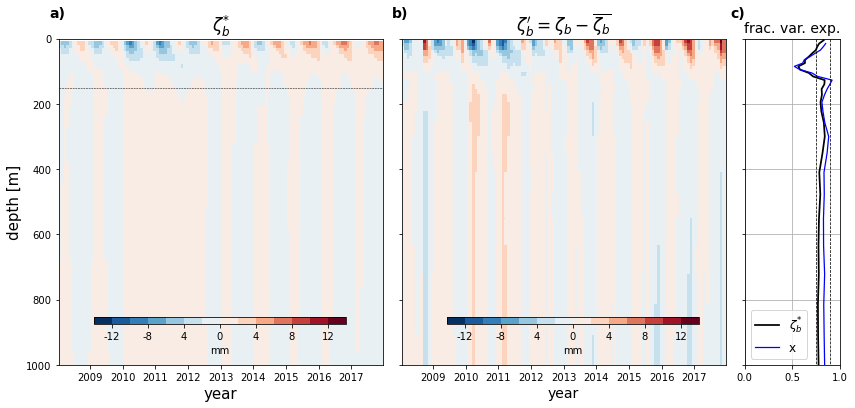

In [153]:
fig = plt.figure(figsize=(14,6))
gs = GridSpec(1, 7, figure=fig)
ax1 = fig.add_subplot(gs[0,0:3])
ax2 = fig.add_subplot(gs[0,3:6])
ax3 = fig.add_subplot(gs[0,6])
cmap_zb = plt.get_cmap('RdBu_r',14)
Kc1 = ax1.pcolor(ecco_monthly_ds.time,pbdeps,pb_est_a,cmap=cmap_zb,vmin=-0.14,vmax=0.14)
ax1.plot(ecco_monthly_ds.time,150*np.ones(len(ecco_monthly_ds.time)),color='k',linestyle='--',linewidth=0.5)
ax1.set_ylabel('depth [m]',fontsize=15); ax1.set_xlabel('year',fontsize=15); ax1.set_ylim([0,1000]);
ax1.set_title(r'$\zeta_{b}^{*}$',fontsize=17); ax1.invert_yaxis()

Kc2 = ax2.pcolor(ecco_monthly_ds.time,-1*v_cell_z,pb_obs_a,cmap=cmap_zb,vmin=-0.14,vmax=0.14)
ax2.set_yticklabels(['']); ax2.set_xlabel('year',fontsize=14); ax2.set_ylim([0,1000]);
ax2.set_title(r"$\zeta_b' = \zeta_{b} - \overline{\zeta_{b}}$",fontsize=17); ax2.invert_yaxis()

# pb_obs_a = (np.transpose(delta_pb_obs - np.nanmean(delta_pb_obs,axis=0))/g/rho0)
# pb_est_a = (deltapbz_total - deltapbz_total.mean(dim=['time']))

pb_skill = 1 - np.nanvar(pb_obs_a - pb_est_a, axis=1)/np.nanvar(pb_obs_a,axis=1)
pb_skill_model = 1 - np.nanvar(pb_obs_a_model - pb_est_a_model, axis=1)/np.nanvar(pb_obs_a_model,axis=1)
pb_skill_wo_trend = 1 - np.nanvar(pb_obs_a_no_trend - pb_est_a_no_trend, axis=1)/np.nanvar(pb_obs_a_no_trend,axis=1)
pb_skill_wo_season = 1 - np.nanvar(pb_obs_a_no_season - pb_est_a_no_season, axis=1)/np.nanvar(pb_obs_a_no_season,axis=1)

cbpos = [0.16, 0.22, 0.25, 0.015]; cax1 = fig.add_axes(cbpos); 
cb1 = f.colorbar(Kc1, cax=cax1, orientation='horizontal', label='mm', ticks=[-.12,-.08,-0.04, 0, 0.04, 0.08, 0.12])
cb1.ax.set_xticklabels(['-12','-8','4','0','4','8','12'])

cbpos = [0.51, 0.22, 0.25, 0.015]; cax = fig.add_axes(cbpos); 
cb2 = f.colorbar(Kc2, cax=cax, orientation='horizontal', label='mm', ticks=[-.12,-.08,-0.04, 0, 0.04, 0.08, 0.12])
cb2.ax.set_xticklabels(['-12','-8','4','0','4','8','12'])

ax3.plot(pb_skill,-1*v_cell_z,color='k',linewidth=1.75, label='$\zeta_b^{*}$')
ax3.plot(pb_skill_model,-1*v_cell_z,color='b',linewidth=1.25, label='x')
ax3.plot([0.75,0.75],[0,1000],color='k',linestyle='--',linewidth=0.75)
ax3.plot([0.9,0.9],[0,1000],color='k',linestyle='--',linewidth=0.75)
# ax3.plot([-0.35,-0.35],[0,1000],color='k',linestyle='--',linewidth=0.75)
# ax3.plot([0.35,0.35],[0,1000],color='k',linestyle='--',linewidth=0.75)
ax3.set_yticklabels(['']); ax3.set_xlim([0,1]); ax3.set_ylim([0,1000]);
ax3.set_title('frac. var. exp.',fontsize=14) 
ax3.invert_yaxis(); ax3.grid(); ax3.legend(loc=3,fontsize=12)

ax1.text(np.datetime64('2007-10-01'),-65,'a)',fontsize=14,fontweight='bold')
ax2.text(np.datetime64('2007-10-01'),-65,'b)',fontsize=14,fontweight='bold')
ax3.text(-0.15,-65,'c)',fontsize=14,fontweight='bold')

# cbpos = [0.92, 0.15, 0.015, 0.4]; cax = f.add_axes(cbpos); cb = f.colorbar(Kc, cax=cax, orientation='vertical', extend='both')
fig.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/manuscript/figures_v2/landerer_predicted_vs_model_obp.jpg', dpi=300)
# fig.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/meetings/2022_07_21/landerer_predicted_vs_model_obp.jpg', dpi=350)

In [229]:
# phase randomization 
data_in = (deltapbz_total - deltapbz_total.mean(dim=['time']))[0,:]
data_in = data_in.data[:,None]
n_s = 1000
scram_trend = np.nan*np.ones((n_s,np.shape(data_in)[1]))
for i in range(0,n_s):
    scram = pharand(data_in)
    u1_da = xr.DataArray(data=scram, dims=["location","time"],
                        coords=dict(
                            location=(["location"], np.arange(0,np.shape(scram)[0])), time=(["time"], deltapbz_total.time.data)))
    slope = u1_da.polyfit(dim='time', deg=1)
    scram_trend[i,:] = (slope.isel(degree=0).polyfit_coefficients.data)*1e9*60*60*24*365
print(np.nanstd(scram_trend))

0.003268202926529504


In [99]:
ds_argo = xr.open_dataset('/Users/jakesteinberg/Documents/NASA_OSTST/argo_obp_50m_2010_2019.nc')
ds_grace = xr.open_dataset('/Users/jakesteinberg/Documents/NASA_OSTST/grace_obp_100m_2010_2019.nc')

Text(0.5, 0, 'year')

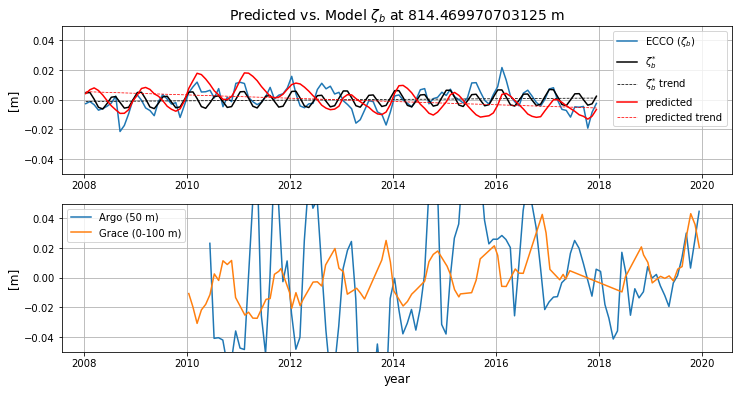

In [124]:
d_i = 26 # depth index 
fit = curve_fit(trend_season_f, time_ord-time_ord[0], pb_obs_a[d_i,:])
model = trend_season_f((time_ord-time_ord[0]),*fit[0])
model_trend = trend_f((time_ord-time_ord[0]),fit[0][4],fit[0][5])
model_season = season_f((time_ord-time_ord[0]),fit[0][0],fit[0][1],fit[0][2],fit[0][3])

f, (ax,ax2) = plt.subplots(2,1,figsize=(12,6),sharey=True)
ax.plot(ecco_monthly_ds.time, pb_obs_a[d_i,:], label=r'ECCO ($\zeta_b$)') 
ax.plot(ecco_monthly_ds.time, model, color='k', linestyle='-', label=r'$\zeta_b^{*}$')
ax.plot(ecco_monthly_ds.time, model_trend, color='k', linestyle='--', linewidth=0.75, label=r'$\zeta_b^{*}$ trend')

fit = curve_fit(trend_season_f, time_ord-time_ord[0], pb_est_a[d_i,:])
model = trend_season_f((time_ord-time_ord[0]),*fit[0])
model_trend = trend_f((time_ord-time_ord[0]),fit[0][4],fit[0][5])
model_season = season_f((time_ord-time_ord[0]),fit[0][0],fit[0][1],fit[0][2],fit[0][3])

ax.plot(ecco_monthly_ds.time, pb_est_a[d_i,:], color='r',label='predicted')
ax.plot(ecco_monthly_ds.time, model_trend, color='r', linestyle='--', linewidth=0.75, label='predicted trend')

ax.set_ylim([-0.05,0.05]); ax.set_ylabel('[m]',fontsize=12); ax.legend() 
ax.set_title(r'Predicted vs. Model $\zeta_b$ at ' + str(-1*v_cell_z[d_i].data) + ' m', fontsize=14)
ax.grid(); 
ax.set_xlim([np.datetime64('2007-08-01'),np.datetime64('2020-08-01')])
# --- ARGO GRACE COMP 
ax2.plot(ds_argo.time,ds_argo.argo_obp,label='Argo (50 m)')
ax2.plot(ds_grace.time,ds_grace.grace_obp, label='Grace (0-100 m)')
ax2.set_xlim([np.datetime64('2007-08-01'),np.datetime64('2020-08-01')])
ax2.grid(); ax2.legend(); ax2.set_ylabel('[m]',fontsize=12)
ax2.set_xlabel('year',fontsize=12)
# f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/meetings/2022_07_21/predicted_vs_obs_obp_all.jpg', dpi=350)

In [154]:
# -- remove time mean from landerer predicted delta pb and fit linear trend at each depth 
test = (deltapbz_total - deltapbz_total.mean(dim=['time']))
p_test = test.polyfit(dim='time', deg=1)
p_test = (p_test.isel(degree=0).polyfit_coefficients)*1e9*60*60*24*365
# test_upper = (deltapbz_total_upper - deltapbz_total_upper.mean(dim=['time']))
# p_test_upper = test_upper.polyfit(dim='time', deg=1)
# p_test_upper = (p_test_upper.isel(degree=0).polyfit_coefficients)*1e9*60*60*24*365

In [155]:
# subset for times when we have argo data 
t_s = '2009-01-01'
t_e = '2017-12-31'
test8 = test.sel(time=slice(t_s, t_e))
p_test8 = test8.polyfit(dim='time', deg=1)
p_test8 = (p_test8.isel(degree=0).polyfit_coefficients)*1e9*60*60*24*365

[Text(0, -2, '-2'),
 Text(0, 0, '0'),
 Text(0, 2, '2'),
 Text(0, 4, '4'),
 Text(0, 6, '6'),
 Text(0, 8, '8'),
 Text(0, 10, '10')]

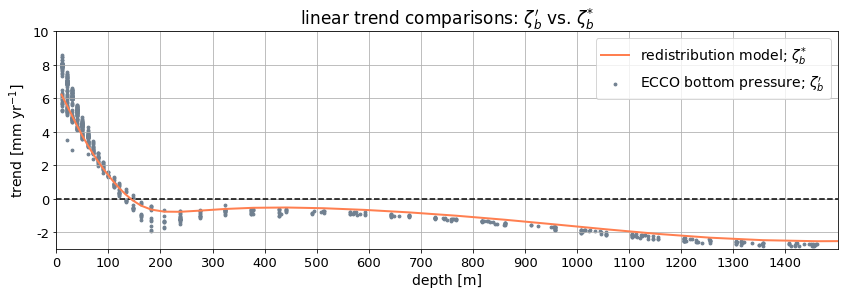

In [156]:
f,ax = plt.subplots(1,1,figsize=(14,4))
ax.plot([0,3000],[0, 0], color='k', linewidth=1.5, linestyle='--')
ax.scatter(dep.isel(tile=tile_num)*gulf_mask, gulf_a_obp*1000, s=8, color='#708090',label="ECCO bottom pressure; $\zeta_{b}'$"); 
# ax.scatter(dep.isel(tile=tile_num)*gulf_mask, gulf_a_sla, s=1, color='m',label='sla trend'); 
ax.plot(pbdeps, p_test*1000, color='#FF7F50', linewidth=2, label='redistribution model; $\zeta_b^{*}$')
# ax.plot(pbdeps, p_test8, color='r', linewidth=2, label='Landerer8')
# ax.plot(pbdeps, p_test_upper, color='#32CD32', linewidth=1.5, label='Landerer in time 0-' + str(np.int(v_cell_z[29])) + 'm')
ax.set_xlim([0,1500]); ax.set_xticks(np.arange(0,1500,100)); ax.set_xlabel('depth [m]',fontsize=14)
ax.set_ylim(np.array([1000])*[-0.003, 0.009]); ax.set_ylabel('trend [mm yr$^{-1}$]',fontsize=14)
ax.grid(); ax.set_title("linear trend comparisons: $\zeta_b'$ vs. $\zeta_b^{*}$",fontsize=17); 
# ax.grid(); ax.set_title("$\zeta_b'$",fontsize=17); 
ax.legend(fontsize=14); ax.set_xticklabels(np.arange(0,1500,100),fontsize=13); 
ax.set_yticks(np.arange(-2,12,2)); ax.set_yticklabels(np.arange(-2,12,2),fontsize=13)
# f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/manuscript/figures_v1/landerer_predicted_trend.jpg', dpi=250)
# f.savefig('/Users/jakesteinberg/Documents/meetings/2022_10_GRACE/obp_vs_depth.jpg', dpi=250)

In [234]:
ecco_landerer_trend = xr.Dataset(
    data_vars=dict(
        p_test=(['depth'], p_test.data),
        p_test8=(['depth'], p_test8.data),
    ),
    coords=dict(
        depth=(["depth"], pbdeps)
    ),
)
ecco_landerer_trend.to_netcdf(path='/Users/jakesteinberg/Documents/NASA_OSTST/ecco_landerer_trend_prediction.nc')

In [29]:
t_s = '2008-01-15'
t_e = '2017-12-15'
test1_time = ecco_monthly_ds.time.data
test1 = lay1_da.sel(time=slice(t_s, t_e))
testb = layb_da.sel(time=slice(t_s, t_e))
layerbylayer = testb.cumsum(dim='zi') - test1
layerbylayer_a = layerbylayer - layerbylayer.mean(dim=['time'])
p1_test = layerbylayer_a.polyfit(dim='time', deg=1)
p1_test = (p1_test.isel(degree=0).polyfit_coefficients)*1e9*60*60*24*365

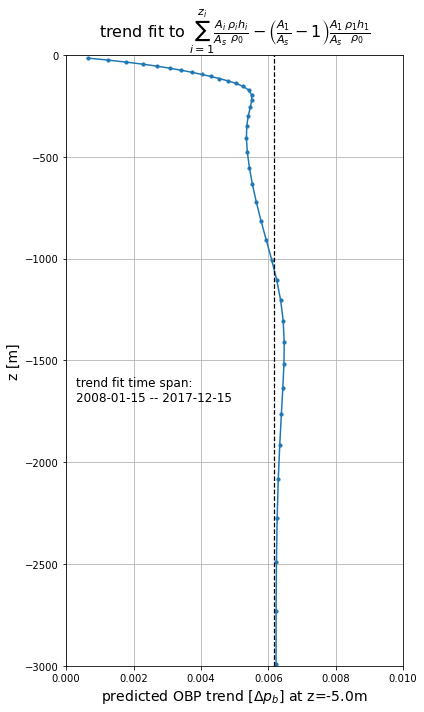

In [31]:
# contributions to layer 1 
f, ax = plt.subplots(1,1,figsize=(6,10))
ax.plot(p1_test,v_cell_z[1:],linewidth=1.5); ax.scatter(p1_test,v_cell_z[1:],s=10)
ax.plot([p_test[0],p_test[0]],[-3000,0],linestyle='--',color='k',linewidth=1.25)
ax.grid(); ax.set_xlabel(r'predicted OBP trend [$\Delta p_b$] at z='+str(v_cell_z[0].data)+'m',fontsize=14)
ax.set_ylabel('z [m]',fontsize=14)
ax.set_title(r'trend fit to $\sum_{i=1}^{z_i} \frac{A_i}{A_s} \frac{\rho_i h_i}{\rho_0} - \left(\frac{A_1}{A_s} - 1 \right) \frac{A_1}{A_s} \frac{\rho_1 h_1}{\rho_0}$',\
            fontsize=16)
ax.text(0.0003,-1625,'trend fit time span:',fontsize=12)
ax.text(0.0003,-1700,'2008-01-15 -- 2017-12-15',fontsize=12)
ax.set_ylim([-3000,0]); ax.set_xlim([0,0.01])
f.tight_layout()
f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/manuscript/figures/predicted_obp_trend_level1.jpg', dpi=250)

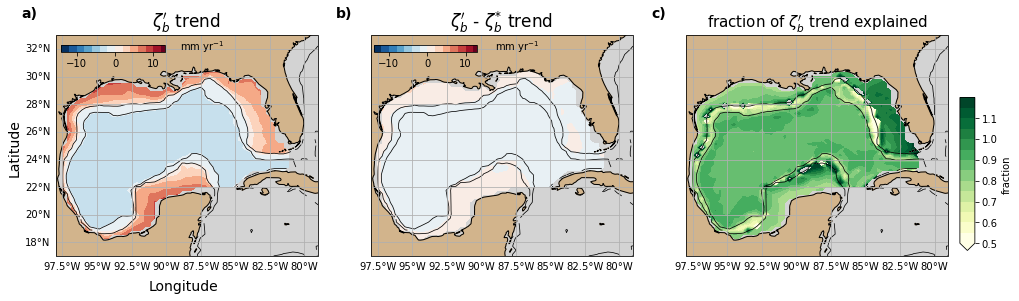

In [177]:
landerer_total_xy = np.nan*np.ones(np.shape(gulf_a_obp))
for i in range(np.shape(gulf_a_obp)[0]):
    for j in range(np.shape(gulf_a_obp)[1]):
        this_dep = dep.isel(tile=tile_num)[j,i].data
        if ~np.isnan(this_dep):
            bot_ind = np.where(pbdeps <= this_dep)[0]
            if len(bot_ind >= 1):
                landerer_total_xy[j,i] = p_test[bot_ind[-1]]

f, (ax,ax2,ax3) = plt.subplots(1,3,figsize=(16,4.25), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)}); 
clim = [-14,14]; #[-0.01, 0.011];
colMap = plt.get_cmap('RdBu_r',14); 
colMap.set_over(color='#660000');
ocean = '#D3D3D3' #'#00FFFF'

Kc0 = ax.contourf(lons,lats, gulf_a_obp*np.array([1000]), levels=np.arange(clim[0], clim[-1], 1), \
            vmin=clim[0],vmax=clim[-1], cmap=colMap, extend='neither', transform=ccrs.PlateCarree()); 
ax.contour(lons, lats, dep.isel(tile=tile_num), [150,1000], linewidths=0.75, colors='k', transform=ccrs.PlateCarree())
ax.set_facecolor(ocean); 
ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1); ax.coastlines()
gl = ax.gridlines(draw_labels=True); gl.ylabels_right = False; gl.xlabels_top = False;

Kc = ax2.contourf(lons,lats, (gulf_a_obp - landerer_total_xy)*np.array([1000]), levels=np.arange(clim[0], clim[-1], 1), \
            vmin=clim[0],vmax=clim[-1], cmap=colMap, extend='neither', transform=ccrs.PlateCarree()); 
ax2.contour(lons, lats, dep.isel(tile=tile_num), [150,1000], linewidths=0.75, colors='k', transform=ccrs.PlateCarree())
ax2.set_facecolor(ocean); 
ax2.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1); ax2.coastlines()
gl = ax2.gridlines(draw_labels=True); gl.ylabels_left = False; gl.ylabels_right = False; gl.xlabels_top = False;

colmapfrac = plt.get_cmap('YlGn',14)
Kc = ax3.contourf(lons,lats, (landerer_total_xy)/gulf_a_obp, levels=np.arange(0.5,1.201,0.001), \
            vmin=0.5,vmax=1.2, extend='min', cmap=colmapfrac, transform=ccrs.PlateCarree()); 
ax3.contour(lons, lats, dep.isel(tile=tile_num), [150,1000], linewidths=0.75, colors='k', transform=ccrs.PlateCarree())
ax3.set_facecolor(ocean); 
ax3.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1); ax3.coastlines()
gl = ax3.gridlines(draw_labels=True); gl.ylabels_left = False; gl.ylabels_right = False; gl.xlabels_top = False;

ax.set_title("$\zeta_b'$ trend",fontsize=17)
# ax.text(-97,31,'(mean=' + str(np.round(mean_gulf_trend,5)) + ' m / yr)')
ax2.set_title("$\zeta_b'$ - $\zeta_b^{*}$ trend",fontsize=17)
ax3.set_title("fraction of $\zeta_b'$ trend explained",fontsize=15)

ax.set_xlim([lon_w, -79]); ax.set_ylim([17, 33])
ax2.set_xlim([lon_w, -79]); ax2.set_ylim([17, 33])
ax3.set_xlim([lon_w, -79]); ax3.set_ylim([lat_s, 33])
ax.set_xlabel('Longitude',fontsize=13); ax.set_ylabel('Latitude',fontsize=13)

ax.text(lon_w-2.5,33+1.25,'a)',fontsize=14,fontweight='bold')
ax2.text(lon_w-2.5,33+1.25,'b)',fontsize=14,fontweight='bold')
ax3.text(lon_w-2.5,33+1.25,'c)',fontsize=14,fontweight='bold')

cbpos = [0.91, 0.16, 0.013, 0.5]; cax = f.add_axes(cbpos); 
cb = f.colorbar(Kc, cax=cax, orientation='vertical', extend='min', label='fraction', ticks=[0.5,0.6,0.7,0.8,0.9,1,1.1])
cbpos = [0.13, 0.81, 0.09, 0.02]; cax = f.add_axes(cbpos); 
cb = f.colorbar(Kc0, cax=cax, orientation='horizontal', extend='neither', ticks=[-10,0,10])
cbpos = [0.401, 0.81, 0.09, 0.02]; cax = f.add_axes(cbpos); 
cb = f.colorbar(Kc0, cax=cax, orientation='horizontal', extend='neither', ticks=[-10,0,10])
ax.text(-89,31.85,'mm yr$^{-1}$')
ax2.text(-89,31.85,'mm yr$^{-1}$')
ax.text(-91.25,14.5,'Longitude',fontsize=14)
ax.text(-101.5,23,'Latitude',rotation=90,fontsize=14)
f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/manuscript/figures_v2/f7_landerer_frac_explained.jpg', dpi=300)
# f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/meetings/2022_09_01/landerer_frac_explained.jpg', dpi=250)

In [159]:
lon_e

-80